In [12]:
"""
SELECT players.username, team, level_index, highscore
  FROM players
  JOIN highscores ON players.username=highscores.username
  INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/stars.txt';
"""

"\nSELECT players.username, team, level_index, score\n  FROM players\n  JOIN highscores ON players.username=highscores.username\n  INTO OUTFILE 'C:/ProgramData/MySQL/MySQL Server 8.0/Uploads/foo.txt';\n"

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as spstats
import random
%matplotlib inline

In [96]:
star_thresholds = {
    1: None,
    2: (920, 1000),
    3: (1100, 1900),
    4: (2000, 2800),
    5: (1000, 1500),
    6: (700, 750),
    7: (885, 1080),
    8: (850, 900),
    9: (1650, 1700),
    10: (1000, 1100),
    11: (1300, 1500),
    12: (1200, 1500),
    13: (3000, 4000),
    14: (950, 1000),
    15: (950, 1000),
    16: (1300, 1600),
    17: (970, 1000),
    18: (3800, 4200)
}

In [171]:
rows = []
research = []
with open('stars.txt') as f:
    for line in f:
        name,team,lid,score = line.split('\t')
        team = int(team)
        lid = int(lid)
        score = int(score)
        if team < 0:
            continue
        if lid not in star_thresholds.keys():
            research.append([name, team, lid, score])
        else:
            if lid==1:
                stars = 0
            else:
                t2,t3 = star_thresholds[lid]
                stars = 3 if score >= t3 else 2 if score >= t2 else 1

            rows.append([name, team, lid, score, stars])
        
df_res = pd.DataFrame(research, columns=['username','team','lid','score'])
df = pd.DataFrame(rows, columns=['username','team','lid','score','stars'])
df.head()

,username,team,lid,score,stars
0,135Mallos,0,1,0,0
1,135Mallos,0,2,1003,3
2,135Mallos,0,3,1931,3
3,135Mallos,0,4,2896,3
4,135Mallos,0,5,1010,2


/home/jz/.local/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/home/jz/.local/lib/python3.6/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


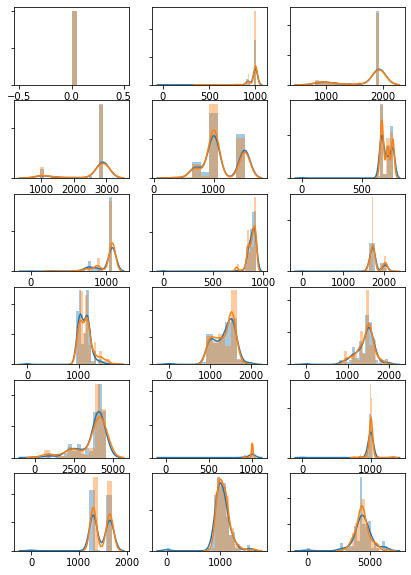

In [189]:
# stars per level... not interesting

fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(7,10))
levels_grouped = df.groupby('lid')
for level_idx in range(1,19):
    df_level = levels_grouped.get_group(level_idx)
    score0 = list(df_level.loc[df_level['team'] == 0]['score'])
    score1 = list(df_level.loc[df_level['team'] == 1]['score'])
    
    i = level_idx-1
    ax = axes[(i//3,i%3)]
    ax.set_yticklabels([])
    
    def foo(ax, hist, kde, rug):
        sns.distplot(score0, ax=ax, hist=hist, kde=kde, rug=rug)
        sns.distplot(score1, ax=ax, hist=hist, kde=kde, rug=rug)
    foo(ax, True, True, False)

In [173]:
# extract stars and progress
grouped = df.groupby('username')
stars = grouped['stars'].sum()
teams = grouped['team'].first()
progress = grouped['lid'].max()

stars0 = []
stars1 = []
progress0 = []
progress1 = []
for name in stars.keys():
    if teams[name] == 0:
        stars0.append(stars[name])
        progress0.append(progress[name])
    else:
        stars1.append(stars[name])
        progress1.append(progress[name])

In [190]:
print(len(progress0), len(progress1))
print(len(progress0) + len(progress1))

414 428
842


In [175]:
def bs_permute(dist1, dist2, func, size):
    distboth = np.concatenate((dist1,dist2))
    
    bs_samples = np.empty(size)
    for i in range(size):
        scrambled = np.random.permutation(distboth)
        perm1 = scrambled[:len(dist1)]
        perm2 = scrambled[len(dist1):]
        bs_samples[i] = func(perm1, perm2)
        
    return bs_samples

def diff_meds(dist1, dist2):
    return np.median(dist1) - np.median(dist2)
    
def test_median(dist1, dist2, size):
    gtruth_dmed = diff_meds(dist1, dist2)
    sample_dmeds = bs_permute(dist1, dist2, diff_meds, size)
    
    pval = np.sum(sample_dmeds >= gtruth_dmed) / len(sample_dmeds)
    return pval

In [180]:
progress_pval = test_median(progress0, progress1, 100000)
stars_pval = test_median(stars0, stars1, 100000)
print(f'pp={progress_pval} sp={stars_pval}')

pp=0.02845 sp=0.13396


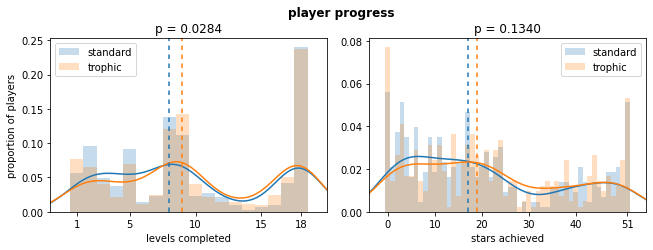

In [181]:
#plot histograms

fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
fig.tight_layout()

# hists
pbins = np.arange(1,20)-.5
sbins = np.arange(0,53)-.5
sns.distplot(progress1, hist_kws=dict(alpha=.25), ax=axes[0], bins=pbins)
sns.distplot(progress0, hist_kws=dict(alpha=.25), ax=axes[0], bins=pbins)
sns.distplot(stars1, hist_kws=dict(alpha=.25), ax=axes[1], bins=sbins)
sns.distplot(stars0, hist_kws=dict(alpha=.25), ax=axes[1], bins=sbins)

axes[0].legend(['standard','trophic'])
axes[1].legend(['standard','trophic'])

axes[0].set_ylabel('proportion of players')
axes[0].set_xlabel('levels completed')
axes[1].set_xlabel('stars achieved')

# medians
cmap = plt.get_cmap('tab10')
smed0 = np.median(stars0)
smed1 = np.median(stars1)
pmed0 = np.median(progress0)
pmed1 = np.median(progress1)
axes[0].axvline(pmed0, color=cmap(.1), ls=(0,[3,3]))
axes[0].axvline(pmed1, color=cmap(0), ls=(0,[3,3]))
axes[1].axvline(smed0, color=cmap(.1), ls=(0,[3,3]))
axes[1].axvline(smed1, color=cmap(0), ls=(0,[3,3]))

# ticks
# axes[0].tick_params(axis='y', which='both', left=False, labelleft=False)
# axes[1].tick_params(axis='y', which='both', left=False, labelleft=False)
axes[0].set_xlim([-1,20])
axes[1].set_xlim([-4,55])
axes[0].set_xticks([1,5,10,15,18])
axes[1].set_xticks([0,10,20,30,40,51])
axes[0].set_title(f'p = {progress_pval:.4f}')
axes[1].set_title(f'p = {stars_pval:.4f}')

plt.suptitle('player progress', fontweight='bold', y=1.08)
plt.savefig('results/learning/stars.pdf', bbox_inches='tight')

101 0:64123.0 1:75170.0
p0:0.9271 p1:0.0962
102 0:20003942.0 1:21026043.0
p0:0.709 p1:0.282
103 0:5009218.5 1:5506430.5
p0:0.8303 p1:0.1634


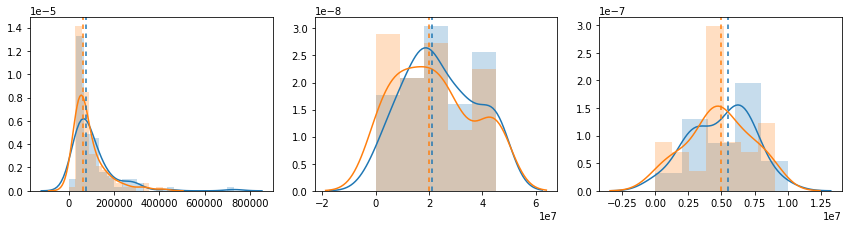

In [188]:
fig,axes = plt.subplots(nrows=1, ncols=3, figsize=(12,3))
fig.tight_layout()

lid_grouped = df_res.groupby('lid')
for lid in lid_grouped.groups.keys():
    df_lvl = lid_grouped.get_group(lid)#.sort_values('score', ascending=False).head(20)
    
    grouped = df_lvl.groupby('username')
    scores = grouped['score'].max()
    teams = grouped['team'].first()

    scores0 = []
    scores1 = []
    for name in scores.keys():
        if teams[name] == 0:
            scores0.append(scores[name])
        else:
            scores1.append(scores[name])
            
    ax = axes[lid-101]
    sns.distplot(scores1, hist_kws=dict(alpha=.25), ax=ax)
    sns.distplot(scores0, hist_kws=dict(alpha=.25), ax=ax)
    
    med0 = np.median(scores0)
    med1 = np.median(scores1)
    ax.axvline(med0, color=cmap(.1), ls=(0,[3,3]))
    ax.axvline(med1, color=cmap(0), ls=(0,[3,3]))

    print(f'{lid} 0:{med0} 1:{med1}')
    pval0 = test_median(scores0, scores1, 10000)
    pval1 = test_median(scores1, scores0, 10000)
    print(f'p0:{pval0} p1:{pval1}')